# Introduction to Dask

Dask is a library for parallel and distributing computing. Similar to Spark

4 main types of APIs:

1. Tasks (Futures) - parallelize arbitrary for-loop style
2. DataFrames - parallelize pandas library (most similar to Spark)
3. Arrays - perform sophisticated operations on larger datasets (most similar to NumPy)
4. Bags - parallel lists (most similar to Spark RDD and Python iterators)

![getting started](https://docs.dask.org/en/stable/_images/dask-overview.svg)

# Creating Dask Objects

In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

# train and test sets
datapath = "D:/Projects/abalone"

## DataFrames

In [2]:
# DataFrames
index = pd.date_range("2021-09-01", periods=2400, freq='1h')
df = pd.DataFrame({
  "a": np.arange(2400),
  "b": list("abcaddbe" * 300)},
  index=index
)
ddf = dd.from_pandas(df, npartitions=10)
ddf

,a,b
npartitions=10,,
2021-09-01 00:00:00,int32,string
2021-09-11 00:00:00,...,...
...,...,...
2021-11-30 00:00:00,...,...
2021-12-09 23:00:00,...,...


In [4]:
# check the index values coverd by each partition
ddf.divisions

(Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-09-11 00:00:00'),
 Timestamp('2021-09-21 00:00:00'),
 Timestamp('2021-10-01 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-10-21 00:00:00'),
 Timestamp('2021-10-31 00:00:00'),
 Timestamp('2021-11-10 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-09 23:00:00'))

In [5]:
# accessing a particular partition
ddf.partitions[1]

,a,b
npartitions=1,,
2021-09-11,int32,string
2021-09-21,...,...


### Indexing

In [6]:
# Accessing a column - as a series
ddf['b']

Dask Series Structure:
npartitions=10
2021-09-01 00:00:00    string
2021-09-11 00:00:00       ...
                        ...  
2021-11-30 00:00:00       ...
2021-12-09 23:00:00       ...
Dask Name: getitem, 2 expressions
Expr=df['b']

In [7]:
# Indexing on a range of values
ddf["2021-10-01":"2021-10-09 5:00"]

,a,b
npartitions=1,,
2021-10-01 00:00:00.000000000,int32,string
2021-10-09 05:00:59.999999999,...,...


### Computation

Dask gets computed into pandas data type

In [10]:
ddf["2021-10-01": "2021-10-09 5:00"].compute()

,a,b
2021-10-01 00:00:00,720,a
2021-10-01 01:00:00,721,b
2021-10-01 02:00:00,722,c
2021-10-01 03:00:00,723,a
2021-10-01 04:00:00,724,d
...,...,...
2021-10-09 01:00:00,913,b
2021-10-09 02:00:00,914,c
2021-10-09 03:00:00,915,a
2021-10-09 04:00:00,916,d


In [13]:
# methods are called similar to pandas or numpy methods
ddf['a'].mean()

<dask_expr.expr.Scalar: expr=df['a'].mean(), dtype=float64>

In [14]:
ddf['a'].mean().compute()

1199.5

## Arrays

In [20]:
import numpy as np
import dask.array as da

data = np.arange(100_000).reshape(200, 500)

# Create 10 chunks of (100, 100) from an array of (200, 500)
a = da.from_array(data, chunks=(100, 100))
a

dask.array<array, shape=(200, 500), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

In [21]:
# inspect the chunks
a.chunks

((100, 100), (100, 100, 100, 100, 100))

In [22]:
# access a particular block of data
a.blocks[1, 3]

dask.array<blocks, shape=(100, 100), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

### Indexing

In [23]:
a[:50, 200]

dask.array<getitem, shape=(50,), dtype=int32, chunksize=(50,), chunktype=numpy.ndarray>

### Computation

Evalauates to Numpy

In [25]:
a[:50, 200].compute()

array([  200,   700,  1200,  1700,  2200,  2700,  3200,  3700,  4200,
        4700,  5200,  5700,  6200,  6700,  7200,  7700,  8200,  8700,
        9200,  9700, 10200, 10700, 11200, 11700, 12200, 12700, 13200,
       13700, 14200, 14700, 15200, 15700, 16200, 16700, 17200, 17700,
       18200, 18700, 19200, 19700, 20200, 20700, 21200, 21700, 22200,
       22700, 23200, 23700, 24200, 24700])

### Methods

In [26]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [27]:
a.mean().compute()

49999.5

In [29]:
a.T

dask.array<transpose, shape=(500, 200), dtype=int32, chunksize=(100, 100), chunktype=numpy.ndarray>

## Bag

Bags __do not__ guarantee ordering among elements

In [33]:
# 8 items composed of 2 partitions of 4 items each
b = db.from_sequence([1, 2, 3, 4, 5, 6, 2, 1], npartitions=2)
b

dask.bag<from_sequence, npartitions=2>

### Indexing

No way to index since they aren't ordered

### Computation

In [37]:
b.compute()

[1, 2, 3, 4, 5, 6, 2, 1]

### Methods

Able to run commands like `map`, `filter`, `fold` and `groupby`

In [39]:
b.filter(lambda x: x % 2)

dask.bag<filter-lambda, npartitions=2>

In [40]:
b.filter(lambda x: x % 2).compute()

[1, 3, 5, 1]

In [41]:
c = db.zip(b, b.map(lambda x: x * 10))
c

dask.bag<zip, npartitions=2>

In [42]:
c.compute()

[(1, 10), (2, 20), (3, 30), (4, 40), (5, 50), (6, 60), (2, 20), (1, 10)]

## Visualize the task graph

Inspect the order of operations Dask is taking using the task graph

In [8]:
import os
os.environ["PATH"] += os.pathsep + "D:/Software/dev_env/Lib/site-packages/graphviz"

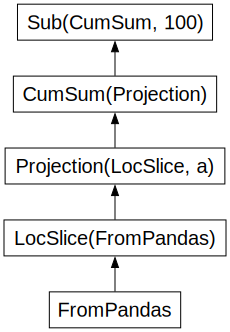

In [3]:
result = ddf["2021-10-01": "2021-10-09 5:00"].a.cumsum() - 100
result.visualize()

In [30]:
b = a.max(axis=1)[::-1] + 10
b.dask

HighLevelGraph with 6 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x245bb0b4820>
 0. array-99e5b459a20ac4145e080e2eb91a2790
 1. chunk_max-43bbfa423dcfaf6482bfad3bae7e4e03
 2. chunk_max-partial-0fb1af23777be0d7cfcfd77984b9d236
 3. max-aggregate-46701eab67b17370a3b8e6a8253aee7d
 4. getitem-a45e54bb97481d09dc3c063555cc84af
 5. add-ffb92ee4a5dcf872abec0d7136283d94

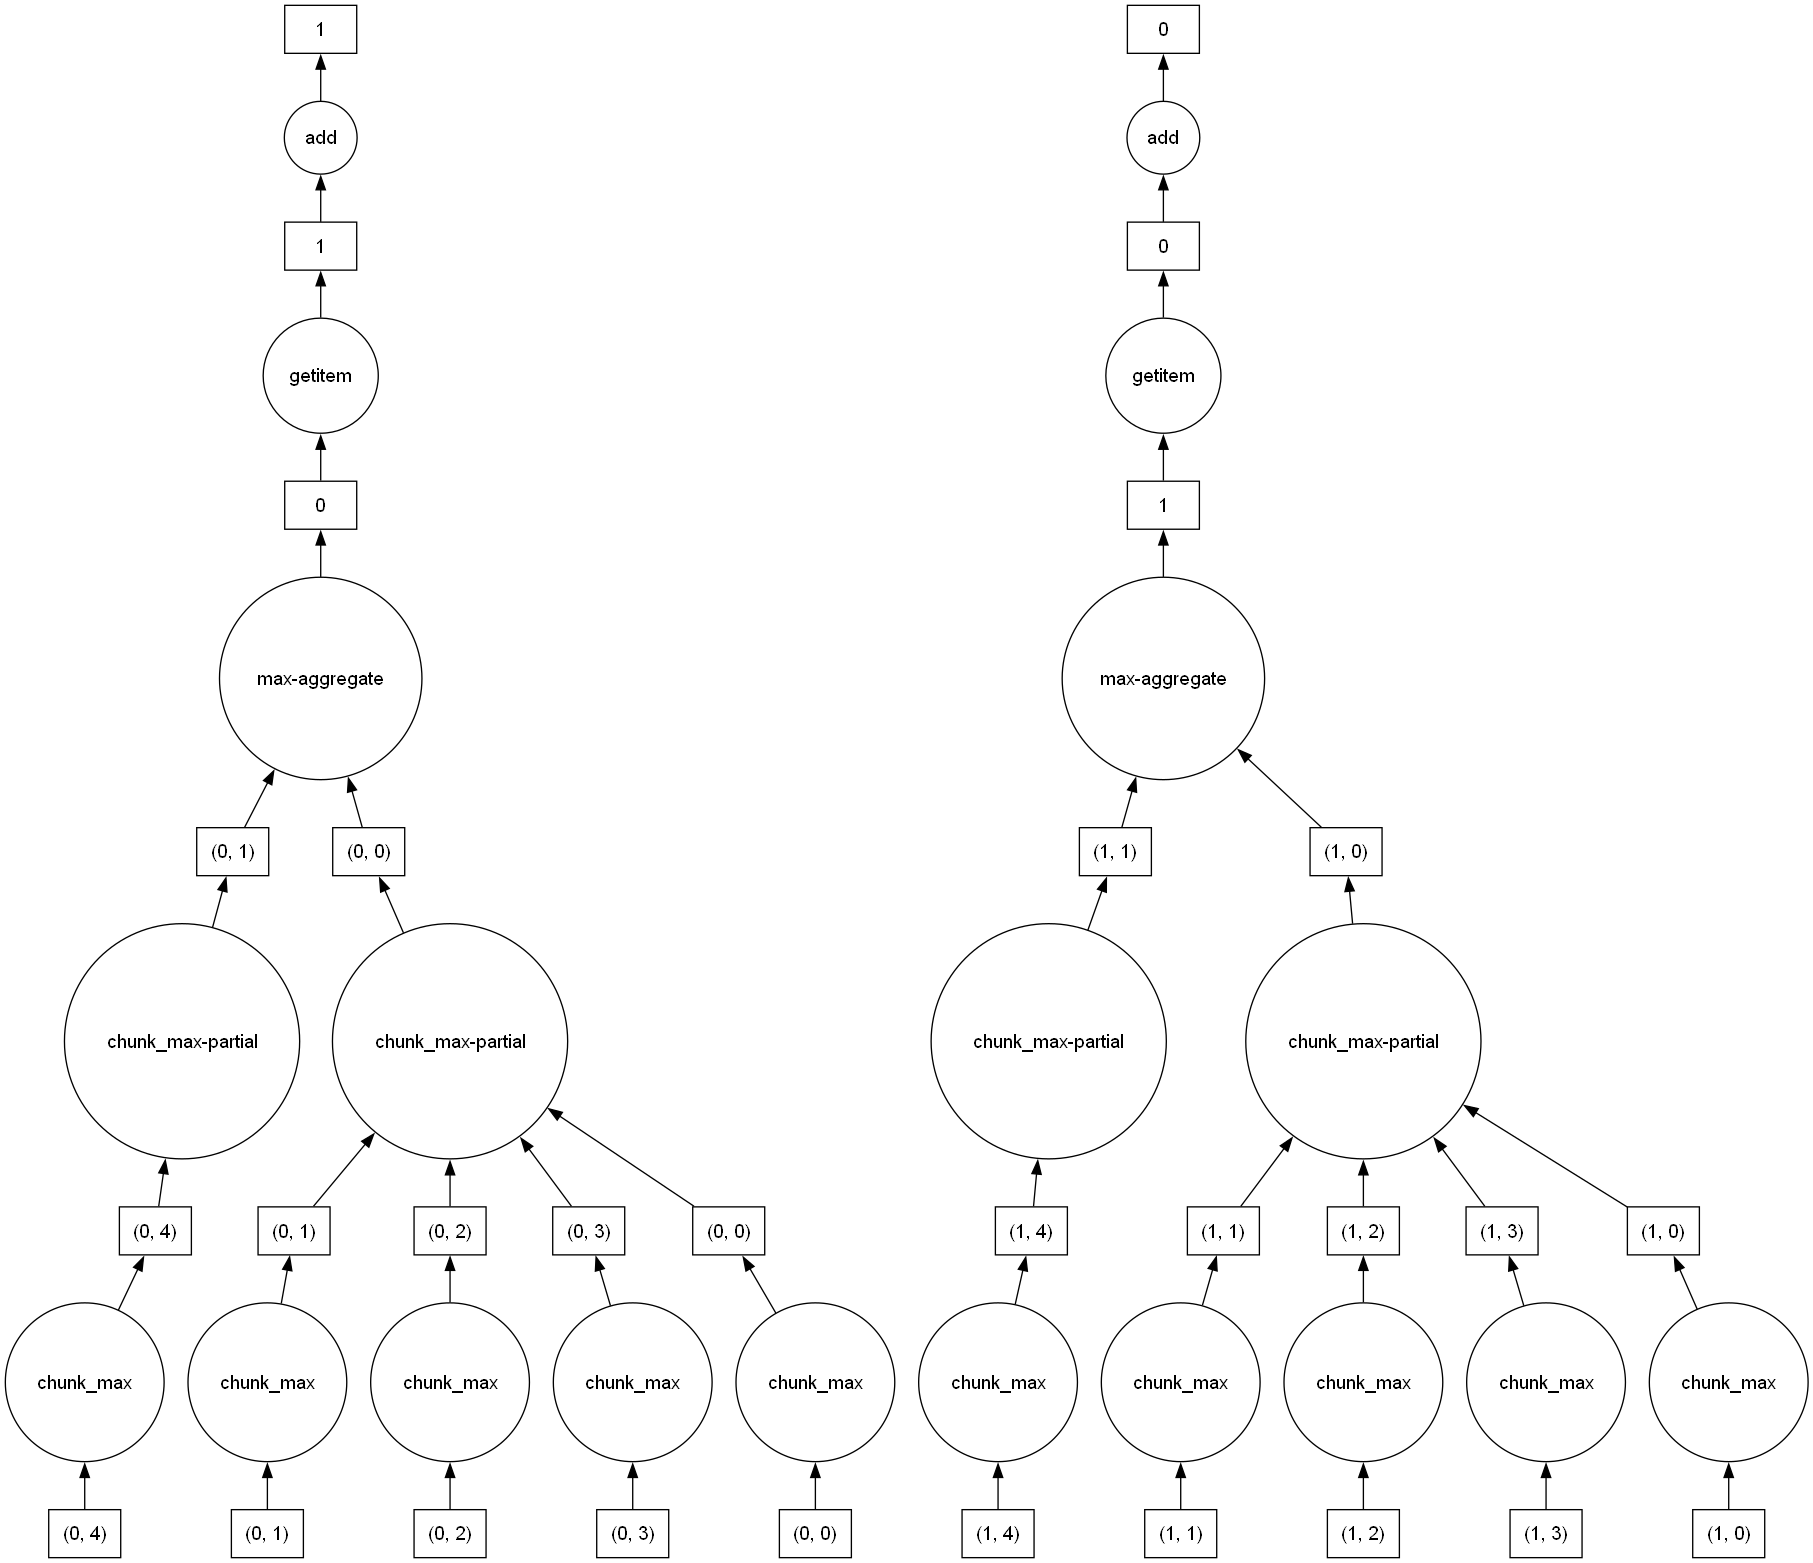

In [31]:
b.visualize()

In [43]:
c.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x245baf19fd0>
 0. from_sequence-8869362cd1b59c4cd089d825f3fb48a1
 1. lambda-a953a9d34922d5edca72b83bbb25cd20
 2. zip-956e1f1c2652ba68fc5adc18d9899e0d

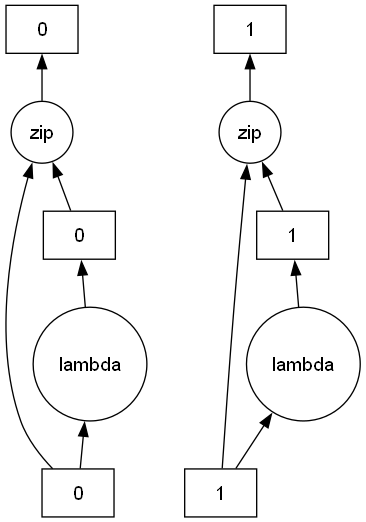

In [44]:
c.visualize()

## Low-Level Interfaces

Code that is parallelizable but isn't on a DataFrame of Array

* __Lazy__ - (Dask Delayed) lets you wrap individual function calls into a lazily constructed task graph
* __Futures__ - (Distributed) futures are eager. Computation starts when function is submitted

In [12]:
# Lazy
import dask

@dask.delayed
def inc(x):
  return x + 1

@dask.delayed
def add(x, y):
  return x + y

a = inc(1)    # no work has happened yet
b = inc(2)    # no work has happened yet
c = add(a, b) # no work has happened yet

c = c.compute() # Triggers all the above computations
c

5

In [11]:
# Immediate
from dask.distributed import Client

client = Client()

def inc(x):
  return x + 1

def add(x, y):
  return x + y

a = client.submit(inc, 1)      # work starts immediately
b = client.submit(inc, 2)      # work starts immediately
c = client.submit(add, a, b)   # work starts immediately
c.result()

d:\Software\dev_env\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61472 instead
  warnings.warn(


5

## Scheduling

The scheduler is what executes the jobs in parallel

By default, calling `compute` will allow Dask to use the thread pool to run computations in parallel. Only _Dask Bag_ uses the multiprocessing scheduler

To have more control, use the distributed scheduler

In [13]:
from dask.distributed import Client

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61472/status,
Dashboard: http://127.0.0.1:61472/status,Workers: 5
Total threads: 20,Total memory: 15.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61475,Workers: 5
Dashboard: http://127.0.0.1:61472/status,Total threads: 20
Started: Just now,Total memory: 15.84 GiB
Comm: tcp://127.0.0.1:61507,Total threads: 4
Dashboard: http://127.0.0.1:61508/status,Memory: 3.17 GiB
Nanny: tcp://127.0.0.1:61478,
